In [186]:
import sklearn
from scipy.stats import bootstrap as boot
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.set_theme()

In [5]:
df = pd.read_csv('arctic1008_new.csv')
df

,Unnamed: 0,City,P_avg_per_m_sec,Population,P_avg_per_m_new,Expl_t_avg_sec,month,dummy_space,dummy_time,year,t,Reg_russian,Reg,Federal_district,lat,lon,city_id,month_dt
0,0,Абаза,39990,12272,NaN,NaN,4,0,0,2022,40,Республика Хакасия,respublika-khakasiya,Сибирский,52.65000,90.08333,137,2022-04-01
1,1,Абаза,29263,12272,NaN,NaN,5,0,0,2022,41,Республика Хакасия,respublika-khakasiya,Сибирский,52.65000,90.08333,137,2022-05-01
2,2,Абаза,36952,12272,NaN,7 д 1 ч,6,0,0,2022,42,Республика Хакасия,respublika-khakasiya,Сибирский,52.65000,90.08333,137,2022-06-01
3,3,Абаза,30629,12272,NaN,124 д,7,0,0,2022,43,Республика Хакасия,respublika-khakasiya,Сибирский,52.65000,90.08333,137,2022-07-01
4,4,Абаза,22034,12272,NaN,25 д 9 ч,8,0,0,2022,44,Республика Хакасия,respublika-khakasiya,Сибирский,52.65000,90.08333,137,2022-08-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11903,11903,Лабытнанги,110075,25501,NaN,NaN,5,1,0,2024,65,Ямало-Ненецкий автономный округ,yamalo-nenetskiy-avtonomniy-okrug,Уральский,66.65806,66.38389,471,2024-05-01
11904,11904,Муравленко,110122,29233,NaN,NaN,5,1,0,2024,65,Ямало-Ненецкий автономный округ,yamalo-nenetskiy-avtonomniy-okrug,Уральский,63.79444,74.49722,753,2024-05-01
11905,11905,Новый Уренгой,186632,107251,NaN,NaN,5,1,0,2024,65,Ямало-Ненецкий автономный округ,yamalo-nenetskiy-avtonomniy-okrug,Уральский,66.08472,76.67889,104,2024-05-01
11906,11906,Ноябрьск,143567,100188,NaN,NaN,5,1,0,2024,65,Ямало-Ненецкий автономный округ,yamalo-nenetskiy-avtonomniy-okrug,Уральский,63.20167,75.45167,801,2024-05-01


In [341]:
control_cities = list(set(list(df.query('dummy_space== 0')['city_id'])))

In [342]:
len(control_cities)

435

In [349]:
import random
random.seed(37)
group_of_items = control_cities  
num_to_select = 23                           
list_of_random_items = random.sample(group_of_items, num_to_select)
df['placebo_flg'] = df['city_id'].apply(lambda x: int(x in list_of_random_items))

In [339]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

def synth_ci(df
    , id_name = 'city_id' 
    , t_name = 'month_dt'
    , dummy_space_name = 'dummy_space' 
    , t_treatment = '2023-12-01'
    , y_name = 'P_avg_per_m_sec'):
    
    df['city_id'] = df['city_id'].astype(str)    
    
    res1 = pd.DataFrame({t_name:df[t_name]}).drop_duplicates()


    def sc(city_id_list:list):
        '''Функция, которая принимает на вход DataFrame с id городов 
        и выдаёт временной ряд среднего эффекта воздействия'''
        sub_df = df[df[id_name].apply(lambda x: x in city_id_list)]
        treatment_cities = list(set(list(sub_df.query(dummy_space_name+'== 1')[id_name])))
        
        res = pd.DataFrame()
        #Идём по городам воздействия
        if len(treatment_cities) == 0:
            return np.nan
        for city in treatment_cities:
            #Берём один город воздействия и все контрольные
            tmp = sub_df[(sub_df[id_name] == city) | (sub_df[id_name].apply(lambda x: x not in treatment_cities))]
            tmp = tmp.pivot(index = t_name, columns = id_name, values = y_name).reset_index()
            res[t_name] = tmp[t_name]
            
            #Обучаем линейную регрессию на претренде
            train = tmp.loc[tmp[t_name] < t_treatment]
            lr = Lasso(alpha=1e8)
            lr.fit(train.drop(columns = [city, t_name]), train[city])
            #Записываем в результат разницу между истинным значением и предиктом
            res[city] = tmp[city] - lr.predict(tmp.drop(columns = [city, t_name]))

            # model = ARDL(endog =train[city]
            #      ,exog= train.drop(columns = [city, t_name])
            #      , lags = 1 )
            # model.fit()
            # res[city] = tmp[city] - model.predict(exog_oos=(tmp.loc[tmp[t_name] >= t_treatment]).drop(columns = [city, t_name]))
        
        return np.mean(res.iloc[:, 1:], axis = 1)
    cities_list = list(set(list(df[id_name])))

    res1['diff'] = sc(cities_list)
    
    # Тут пишем бутстрап
    
    b = boot((cities_list,), sc, n_resamples=1000, method = 'basic')

    res1['lower'] = b.confidence_interval.low
    res1['upper'] = b.confidence_interval.high

    return res1

In [384]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from datetime import datetime

def synth_ci_new(df
    , alpha:float
    , id_name = 'city_id' 
    , t_name = 'month_dt'
    , dummy_space_name = 'dummy_space' 
    , t_treatment = '2023-12-01'
    , y_name = 'P_avg_per_m_sec'
    , trend = False
    , placebo = False
    , dummies = True
    ):
    
    df['city_id'] = df['city_id'].astype(str)


    def sc(city_id_list:list):
        '''Функция, которая принимает на вход DataFrame с id городов 
        и выдаёт временной ряд среднего эффекта воздействия'''
        sub_df = df[df[id_name].apply(lambda x: x in city_id_list)]
        treatment_cities = list(set(list(sub_df.query(dummy_space_name+'== 1')[id_name])))
        placebo_cities = list(set(list(sub_df.query('placebo_flg == 1')[id_name])))
        tmps =[]
        if not placebo:
            cities_list = treatment_cities
        else:
            cities_list = placebo_cities

        #Идём по городам воздействия
        if len(cities_list) == 0:
            return np.nan
        for city in cities_list:
            #Берём один город плацебо|воздействия и все контрольные
            tmp = sub_df[(sub_df[id_name] == city) | (sub_df[dummy_space_name] == 0) & (sub_df['placebo_flg'] == 0)]
            #Вытягиваем в столбик и потом конкатенируем
            tmp = tmp.pivot(index = t_name, columns = id_name, values = y_name).reset_index()
            #Добавляем фиктивную переменную города для сдвига
            tmp['tr_city_id'] = city
            tmp['tr_city'] = tmp[city]
            tmp.drop(columns = city, inplace = True)
            tmps += [tmp]        

        tmp = pd.concat(tmps)
        
        if trend:
            #Разница в датах считается в днях, потому что по-другому я не смог
            tmp['t'] = tmp[t_name].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))-datetime.strptime('2022-04-01', '%Y-%m-%d')
            tmp['t'] = tmp['t'].apply(lambda x: abs(x).days)

        if dummies:
            #Делаю фиктивные переменные городов воздействия/плацебо 
            enc = OneHotEncoder(sparse_output=False, drop='first')
            enc_transformed = enc.fit_transform(tmp[['tr_city_id']])
            enc_df = pd.DataFrame(columns=enc.get_feature_names_out(), data=enc_transformed)
            tmp = pd.concat([tmp.reset_index(drop=True), enc_df.reset_index(drop=True)], axis=1)

        tmp.drop(columns = 'tr_city_id', inplace=True)        

        #Обучаем регрессию на претренде
        train = tmp.loc[tmp[t_name] < t_treatment]
        scaler = StandardScaler()
        lr = Lasso(alpha=alpha)
        lr.fit(scaler.fit_transform(train.drop(columns = ['tr_city', t_name])), train['tr_city'])
            #Записываем в результат разницу между истинным значением и предиктом
        res = pd.DataFrame({'y_true':tmp['tr_city'], 'y_predict': lr.predict(scaler.transform(tmp.drop(columns = ['tr_city', t_name])))
                            , t_name:tmp[t_name]}).groupby(t_name, as_index=False).agg('mean')
        return res
    
    cities_list = list(set(list(df[id_name])))

    res1 = sc(cities_list)
    
    # Тут пишем бутстрап
    def boot_sc(df):
        tmp = sc(df)
        return tmp['y_true'] -tmp['y_predict'] 
    b = boot((cities_list,), boot_sc, n_resamples=1000, method = 'basic')

    res1['lower'] = b.confidence_interval.low
    res1['upper'] = b.confidence_interval.high

    return res1

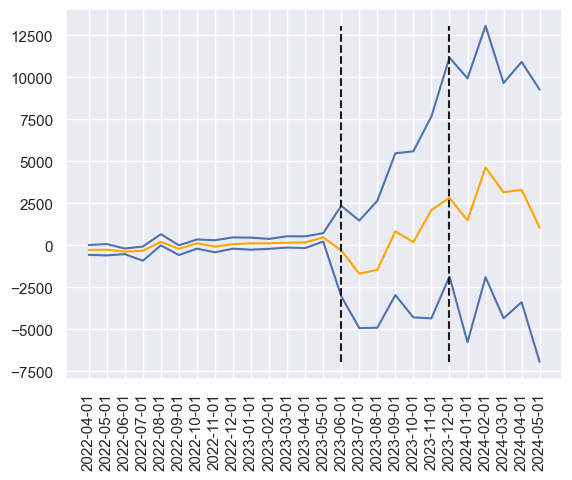

In [385]:
t_treatment= '2023-06-01'
data = synth_ci_new(df, 2e2, t_treatment= t_treatment, trend=True, dummies=True)
data['diff'] = data['y_true'] - data['y_predict']
plt.plot(data['month_dt'], data['diff'], color = 'orange')
plt.xticks(rotation =90)
plt.plot(data['month_dt'], data['upper'], color = 'b')
plt.plot(data['month_dt'], data['lower'], color = 'b')
plt.vlines(x = ['2023-12-01', t_treatment], ymin = data['lower'].min(), ymax = data['upper'].max(), colors='k', linestyles='--')

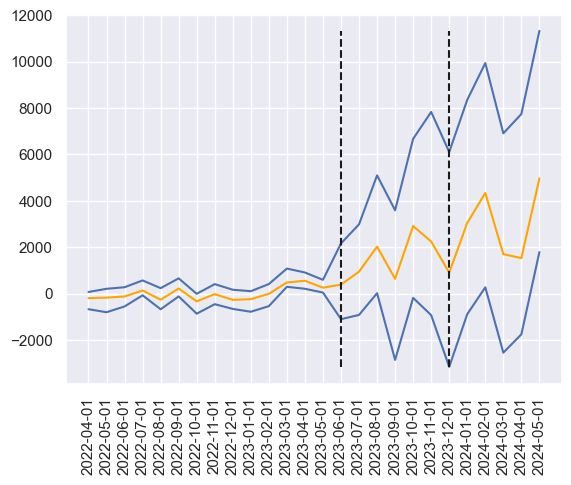

In [386]:
#Плацебо тест на претренде
t_treatment= '2023-06-01'
data = synth_ci_new(df, 2e2, t_treatment= t_treatment, trend=True, placebo = True, dummies = True)
data['diff'] = data['y_true'] - data['y_predict']
plt.plot(data['month_dt'], data['diff'], color = 'orange')
plt.xticks(rotation =90)
plt.plot(data['month_dt'], data['upper'], color = 'b')
plt.plot(data['month_dt'], data['lower'], color = 'b')
plt.vlines(x = ['2023-12-01', t_treatment], ymin = data['lower'].min(), ymax = data['upper'].max(), colors='k', linestyles='--')


c:\Users\unstr\AppData\Local\R-MINI~1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.769e+07, tolerance: 6.851e+07
  model = cd_fast.enet_coordinate_descent(
c:\Users\unstr\AppData\Local\R-MINI~1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.834e+07, tolerance: 4.343e+07
  model = cd_fast.enet_coordinate_descent(
c:\Users\unstr\AppData\Local\R-MINI~1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularis

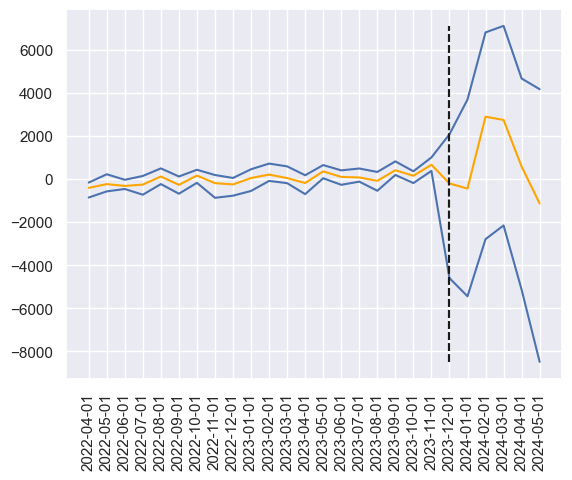

In [387]:
#Эффект воздействия, если обучаться на всём претренде
t_treatment= '2023-12-01'
data = synth_ci_new(df, 2e2, t_treatment= t_treatment, trend=True, dummies=True)
data['diff'] = data['y_true'] - data['y_predict']
plt.plot(data['month_dt'], data['diff'], color = 'orange')
plt.xticks(rotation =90)
plt.plot(data['month_dt'], data['upper'], color = 'b')
plt.plot(data['month_dt'], data['lower'], color = 'b')
plt.vlines(x = ['2023-12-01', t_treatment], ymin = data['lower'].min(), ymax = data['upper'].max(), colors='k', linestyles='--')

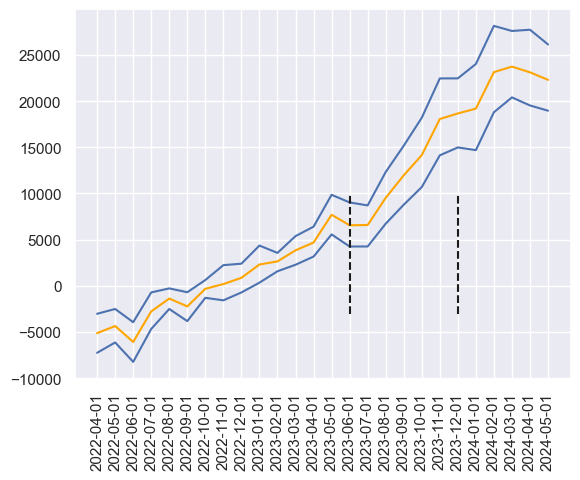

In [340]:
#Плацебо тест на претренде
t_treatment= '2023-06-01'
data = synth_ci(df, t_treatment= t_treatment )
plt.plot(data['month_dt'], data['diff'], color = 'orange')
plt.xticks(rotation =90)
plt.plot(data['month_dt'], data['upper'], color = 'b')
plt.plot(data['month_dt'], data['lower'], color = 'b')
plt.vlines(x = ['2023-12-01', t_treatment], ymin = -3000, ymax = 10000, colors='k', linestyles='--')


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25],
 [Text(0, 0, '2022-04-01'),
  Text(1, 0, '2022-05-01'),
  Text(2, 0, '2022-06-01'),
  Text(3, 0, '2022-07-01'),
  Text(4, 0, '2022-08-01'),
  Text(5, 0, '2022-09-01'),
  Text(6, 0, '2022-10-01'),
  Text(7, 0, '2022-11-01'),
  Text(8, 0, '2022-12-01'),
  Text(9, 0, '2023-01-01'),
  Text(10, 0, '2023-02-01'),
  Text(11, 0, '2023-03-01'),
  Text(12, 0, '2023-04-01'),
  Text(13, 0, '2023-05-01'),
  Text(14, 0, '2023-06-01'),
  Text(15, 0, '2023-07-01'),
  Text(16, 0, '2023-08-01'),
  Text(17, 0, '2023-09-01'),
  Text(18, 0, '2023-10-01'),
  Text(19, 0, '2023-11-01'),
  Text(20, 0, '2023-12-01'),
  Text(21, 0, '2024-01-01'),
  Text(22, 0, '2024-02-01'),
  Text(23, 0, '2024-03-01'),
  Text(24, 0, '2024-04-01'),
  Text(25, 0, '2024-05-01')])

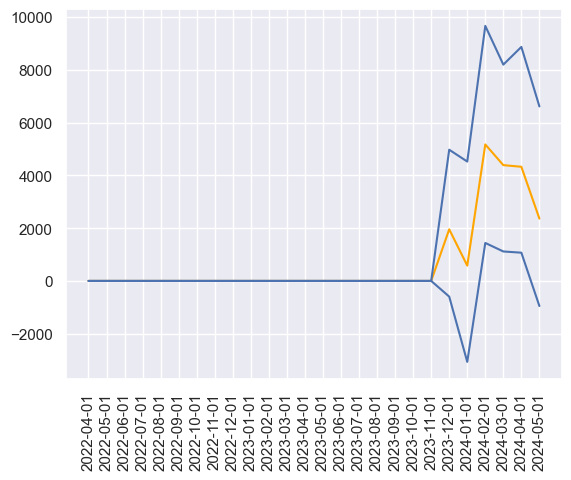

In [155]:
data = synth_ci(df)
plt.plot(data['month_dt'], data['diff'], color = 'orange')
plt.plot(data['month_dt'], data['upper'], color = 'b')
plt.plot(data['month_dt'], data['lower'], color = 'b')
plt.xticks(rotation =90)

In [156]:
data

,month_dt,diff,lower,upper
0,2022-04-01,-6.959612e-12,-3.129626e-11,8.113975e-12
1,2022-05-01,-8.462255e-12,-3.386480e-11,4.298199e-12
2,2022-06-01,-8.066823e-12,-3.120744e-11,3.383284e-12
3,2022-07-01,-2.214422e-12,-1.898076e-11,1.343032e-11
4,2022-08-01,7.908650e-14,-1.335757e-11,1.642473e-11
5,2022-09-01,-2.372595e-12,-1.784581e-11,1.162571e-11
6,2022-10-01,-1.265384e-12,-1.576254e-11,1.429651e-11
7,2022-11-01,2.609854e-12,-6.788653e-12,1.892449e-11
8,2022-12-01,3.163460e-13,-1.132716e-11,1.414843e-11
9,2023-01-01,1.265384e-12,-9.801547e-12,1.465736e-11
